# Projet 2 : Analyse des données de systèmes éducatifs

## 0. Importations des modules et des données

In [66]:
## IMPORTATIONS
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
#% matplotlib notebook
# graphes interactifs
import re
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from IPython.display import Image
#import scipy.stats as st
#import statsmodels.api as sm
#from sklearn.datasets import load_iris
#iris_df_ori = load_iris()

####     A ESSAYER      #######################################################
# GRAPHES INTERACTIFS


# POUR LES GRAPHIQUES
# % matplotlib inline 
# plt.rcParams['figure.figsize'] = [9.5, 6] # ajuster la taille

# POUR DESACTIVER LA TOOLBOX GRAPHES TOP GRANDS
# %%javascript
# IPython.OutputArea.prototype._should_scroll = function(lines) {
#     return false;
# }

In [67]:
## FONCTION SORTANT UN DATAFRAME D'INFOS (complémentaire du describe)

def desc_bis (df):
    nb_li = df.index.size
    nb_col = df.columns.size
    tot = nb_li*nb_col    
    infos = pd.DataFrame(df.dtypes).T.rename(index={0:'Type'}) 
    infos = infos.append(pd.DataFrame(df.isna().sum()).T.rename(index={0:'null'}))
    return infos

In [68]:
def infos (df):
    nb_li = df.shape[0]
    nb_co = df.shape[1]
    t = np.empty(nb_li)
    t.fill(nb_li)
    df_l_null = pd.DataFrame(df.T.isna().sum()) # tableau du nbe de nul par lignes (+800 000 lignes)
    df_c_null = pd.DataFrame(df.isna().sum()) # tableau du nbe de nul par colonnes (+65 colonnes)
    
    # nbe de lignes sans 'null'
    al = len([x for x in df_l_null[0] if x==0])
    nb_ss_null = pd.DataFrame([al]).rename(index={0:'lign_ss_null'}).T
    pct_ss_null = pd.DataFrame([al*100/nb_li]).rename(index={0:'lign_ss_null'}).T
    # nbe de lignes 'null'
    bl = len([x for x in df_l_null[0] if x==nb_co])
    nb_null = pd.DataFrame([bl]).rename(index={0:'lign_null'}).T
    pct_null = pd.DataFrame([bl*100/nb_li]).rename(index={0:'lign_null'}).T
    # nbe de lignes mixtes
    cl = len([x for x in df_l_null[0] if (x!=0 and x!=nb_co)])
    nb_mix = pd.DataFrame([cl]).rename(index={0:'lign_mix'}).T
    pct_mix = pd.DataFrame([cl*100/nb_li]).rename(index={0:'lign_mix'}).T
    infos_nb = pd.concat([nb_ss_null, nb_null, nb_mix],axis=1, sort=False).rename(index={0:'nb'})
    infos_pct = pd.concat([pct_ss_null, pct_null, pct_mix],axis=1, sort=False).rename(index={0:'pct'})
    infos_l = pd.concat([infos_nb,infos_pct], sort=False)
    # nbe de lignes total
    infos_l["lign_tot"] = [infos_l.T['nb'].sum(), infos_l.T['pct'].sum()]
    
    # nbe de colonnes sans 'null'
    ac = len([x for x in df_c_null[0] if x==0])
    nb_ss_null = pd.DataFrame([ac]).rename(index={0:'col_ss_null'}).T
    pct_ss_null = pd.DataFrame([ac*100/nb_co]).rename(index={0:'col_ss_null'}).T
    # nbe de colonnes 'null'
    bc = len([x for x in df_c_null[0] if x==nb_li])
    nb_null = pd.DataFrame([bc]).rename(index={0:'col_null'}).T
    pct_null = pd.DataFrame([bc*100/nb_co]).rename(index={0:'col_null'}).T
    # nbe de colonnes mixtes
    cc = len([x for x in df_c_null[0] if (x!=0 and x!=nb_li)])
    nb_mix = pd.DataFrame([cc]).rename(index={0:'col_mix'}).T
    pct_mix = pd.DataFrame([cc*100/nb_co]).rename(index={0:'col_mix'}).T
    infos_nb = pd.concat([nb_ss_null, nb_null, nb_mix],axis=1, sort=False).rename(index={0:'nb'})
    infos_pct = pd.concat([pct_ss_null, pct_null, pct_mix],axis=1, sort=False).rename(index={0:'pct'})
    infos_c = pd.concat([infos_nb,infos_pct], sort=False)
    # nbe de lignes total
    infos_c["col_tot"] = [infos_c.T['nb'].sum(), infos_c.T['pct'].sum()]
    
    infos = pd.concat([infos_l,infos_c], axis=1, sort=False)
    
    return infos

In [69]:
## FONCTION DE COMPTAGE DES VALEURS NULLES
def evalNull (inf_df):
    a = inf_df.T['null'].sum()
    b = inf_df.T['count'].sum()
    print("Nbe valeurs 'null' : {:.0f}".format(a))
    print("Nbe valeurs non 'null' : {:.0f}".format(b))
    print("Nbe total cases : {:.0f}".format(a+b))
    print("% total valeurs 'null' : {:.1f}%".format(a*100/(a+b)))

In [70]:
# Fonction qui trouve les éléments uniques différents dans deux tableaux
def Diff(tab1, tab2): 
    #tab_dif = [i for i in tab1 + tab2 if i not in tab1 or i not in tab2] # renvoie en vrac toutes les entrées spécifiques
    return (set(tab1)-set(tab2),set(tab2)-set(tab1)) # renvoie deux tableaux spécifiques à tab1 puis tab2

In [71]:
# Fonction vérifiant l'unicité des lignes d'une liste de listes
def uniCle (t_tab): 
    if isinstance(t_tab[0], type(str)) :
        uni = list(set(t_tab))
        res = True if (len(uni)==len(t_tab)) else False
    else :
        uni = list(set(zip(*t_tab))) # liste des combinaisons uniques
        res = True if (len(uni)==len(t_tab[0])) else False
    return res

In [72]:
# Fonction comparant la correspondance unique entre les valeurs d'une même ligne de deux colonnes d'une base
# (bijection entre les valeurs de col1 et de col2)
def Adeq (df, nom_col1,nom_col2):
    mon_zip = zip(df[nom_col1], df[nom_col2]) # associe les entrées des deux colonnes en tuples
    nbe_comb = len(set(mon_zip)) # retourne les valeurs uniques des tuples
    return nbe_comb==df[nom_col1].unique().size # si le nbe est le même que les valeurs uniques, c'est bon

In [73]:
def contAny (cars, mot):
    return any([True if c in cars else False for c in mot])

def contAll (cars, mot):
    return all([True if c in cars else False for c in mot])

def enum_mots_cmpt(li_phrases, nb): # prend une liste de phrases en entrée
    li_mots = " ".join(li_phrases).split(" ")
    li_mots_net = sorted([mot for mot in li_mots if (mot != '') \
                          and not contAll('-)%.(,', mot)])
    cpt = Counter(li_mots_net)
    words_occ = cpt.most_common(nb) # tableau de tuples
    words = [words_occ[i][0] for i in range(len(words_occ))]  
    occs = [words_occ[i][1] for i in range(len(words_occ))]
    dic_occs = dict() 
    for i in range(len(words_occ)):
        dic_occs[words[i]]=occs[i]
    return dic_occs # dictionnaire

def filt_dict(dic_t, li_pop):
    dic = dic_t
    [dic.pop(w) for w in li_pop if w in dic_t.keys()]
    return dic

In [74]:
def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(np.random.randint(70, 120) / 255.0))
    return "hsl({}, {}%, {}%)".format(h, s, l)
tone = 10.0 # define the color of the words

def nuageMots(dic_occs): # prend un dictionnaire {"mot" : nbe occurences}
    fig = plt.figure(figsize=(18,8))
    wordcloud = WordCloud(width=1000,height=200, background_color='black', max_words=1628,\
                      relative_scaling=1, color_func = None, normalize_plurals=False)
    wordcloud.generate_from_frequencies(dic_occs)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    
def histMots(dic_occs): # prend un dictionnaire {"mot" : nbe occurences}
    fig = plt.figure(figsize=(18,4))
    tab_occs = np.array([[k,int(v)] for k,v in dic_occs.items()]).T   # dictionnaire en tableau
    x = tab_occs[0]
    y = tab_occs[1].astype(int)
    x_label = tab_occs[0]
    ax = plt.bar(x, y, align = 'center', color='b')
    plt.xticks(x, x_label, rotation=85, fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.ylabel("Nb. of occurences", fontsize = 18, labelpad = 10)
    plt.title("Fréquence des mots-clés",color='k',fontsize = 18, fontweight = 'bold')
    plt.show() # affiche l'histogramme

In [75]:
## FONCTION D'AFFICHAGE
def basic_plot(plot_type, my_plot, my_x, my_y, my_x_t, xlab, ylab, my_tit, num_col):
    if plot_type == "plot" :
        my_plot.plot(my_x, my_y, '-o', color = colors[num_col])
    elif plot_type == "bar" :
        my_plot.bar(my_x, my_y, color = colors[num_col])
    else :
        print("erreur type de graphe")
    my_plot.set_xlabel(xlab, fontsize = 14)
    my_plot.set_ylabel(ylab, fontsize = 14)
    plt.xticks(my_x_t, my_x_t, rotation=85 , fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.ylim(round(min(my_y)*0.9), round(max(my_y)*1.1)) 
    my_plot.set_title(my_tit, fontsize = 18, fontweight = 'bold')
    plt.grid(color='grey', linestyle='dotted')

L'ensemble des données téléchargées se compose de 5 fichiers .csv et d'un fichier excel comportant 5 onglets.
Il semble que l'intégralité des données des fichiers .csv soit reprise dans chacun des onglets du fichier Excel.

Dans ce notebook, on appellera "base de donnée" l'ensemble des données, et "table" chacun des onglets ou fichier .csv correspondant.

On travaillera sur les cinq dataframes créées dans la cellule suivante :

In [76]:
# Utilisé la fonction dropna (colonne nulle) pour éliminer les colonnes fantômes "Unamed en fin de tableau"
data = pd.read_csv("../DONNEES/EdStatsData.csv").dropna(how='all', axis='columns')
country = pd.read_csv("../DONNEES/EdStatsCountry.csv").dropna(how='all', axis='columns')
cnt_ser = pd.read_csv("../DONNEES/EdStatsCountry-Series.csv").dropna(how='all', axis='columns')
series = pd.read_csv("../DONNEES/EdStatsSeries.csv").dropna(how='all', axis='columns')
footnote = pd.read_csv("../DONNEES/EdStatsFootNote.csv").dropna(how='all', axis='columns')

## 1. Vérification et rectification de la qualité des données

On crée 5 nouvelles dataframes "data_c", "country_c", "series_c", "cnt_ser_c" et "footnote_c" qui contiendront les données rectifiées :

In [77]:
# on crée d'autres dataframes à modifier (deep copies)
data_c = data.copy()
country_c = country.copy()
series_c = series.copy()
cnt_ser_c = cnt_ser.copy()
footnote_c = footnote.copy()

### 1.0 Description globale des tables
#### Comptage des 'null' par lignes et par colonnes pour toutes les  tables 

In [78]:
## COMPTAGE DES 'NULL' par LIGNES et par COLONNES (toutes les tables)
infos_t = pd.concat([infos(data), infos(country), infos(series),\
                  infos(cnt_ser), infos(footnote)], axis = 0,\
                 keys=['data', 'country', 'series', 'cnt_ser', 'footnote'])
pd.options.display.float_format = '{:.1f}'.format
infos_t

lign_ss_null  lign_null  lign_mix  lign_tot  col_ss_null  col_null  col_mix  col_tot
data     nb            0.0        0.0  886930.0  886930.0          4.0       0.0     65.0     69.0
         pct           0.0        0.0     100.0     100.0          5.8       0.0     94.2    100.0
country  nb            0.0        0.0     241.0     241.0          4.0       0.0     27.0     31.0
         pct           0.0        0.0     100.0     100.0         12.9       0.0     87.1    100.0
series   nb            0.0        0.0    3665.0    3665.0          5.0       0.0     10.0     15.0
         pct           0.0        0.0     100.0     100.0         33.3       0.0     66.7    100.0
cnt_ser  nb          613.0        0.0       0.0     613.0          3.0       0.0      0.0      3.0
         pct         100.0        0.0       0.0     100.0        100.0       0.0      0.0    100.0
footnote nb       643638.0        0.0       0.0  643638.0          4.0       0.0      0.0      4.0
         pct         100.0        0.0       0.0     100.0        100.0       0.0      0.0    100.0

#### Table "Data"

In [79]:
inf_data = desc_bis(data).append(data.describe(include='all'))

In [80]:
evalNull(inf_data)
inf_data

Nbe valeurs 'null' : 52568249
Nbe valeurs non 'null' : 8629921
Nbe total cases : 61198170
% total valeurs 'null' : 85.9%


,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
Type,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
null,0,0,0,0,814642,851393,851311,851385,851200,799624,849447,849356,849354,850121,797808,848153,849419,848470,848324,796634,847558,848289,848378,849390,762525,812493,811387,811137,809468,755569,810123,813477,802016,768091,710254,763421,762725,756567,758116,702822,746618,749658,752543,744822,644488,740918,739666,749421,773141,755872,870470,886787,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494
count,886930,886930,886930,886930,72288.0,35537.0,35619.0,35545.0,35730.0,87306.0,37483.0,37574.0,37576.0,36809.0,89122.0,38777.0,37511.0,38460.0,38606.0,90296.0,39372.0,38641.0,38552.0,37540.0,124405.0,74437.0,75543.0,75793.0,77462.0,131361.0,76807.0,73453.0,84914.0,118839.0,176676.0,123509.0,124205.0,130363.0,128814.0,184108.0,140312.0,137272.0,134387.0,142108.0,242442.0,146012.0,147264.0,137509.0,113789.0,131058.0,16460.0,143.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0
unique,242,242,3665,3665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Somalia,NER,Wittgenstein Projection: Percentage of the pop...,HH.MICS.OOST.X.Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3665,3665,242,242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,1974772449.6,4253638470.2,4592364905.3,5105005610.9,5401492903.4,2314287511.6,5731808142.1,6124437154.2,6671488719.0,7436723955.0,3283897508.6,7664969392.5,7913721582.3,7856908292.0,8118001691.3,3622763069.6,9156550107.9,10149008176.4,11047093700.6,11954359464.5,9084423550.7,15716740023.5,16046684980.9,16435324911.6,16840220344.1,10525426793.2,18746300978.4,20273850045.0,17946782924.0,13315578553.5,9423383683.8,13848674153.9,14282985240.2,14493931504.0,15897290510.7,11886369143.0,16846738101.8,18723002078.7,20297938641.7,18949069733.0,11895924324.6,21179108774.0,21763227127.6,24253320032.2,26784486485.5,23537199876.5,193441064053.0,2.2,578.1,605.5,631.6,655.7,675.2,691.1,704.1,714.6,722.5,727.1,728.4,726.6,722.8,717.7,711.3,703.4,694.0
std,NaN,NaN,NaN,NaN,121168685352.0,180481446225.2,191408271479.8,205917043980.7,211214985371.1,137505922744.8,221554619977.1,232548901067.3,247398632281.3,266095745106.0,178077355006.1,274414168518.6,279054890539.2,282380912099.2,294063483007.3,200292918507.1,326467474653.7,353535110136.2,380425690032.6,401487301933.0,366566685061.6,488135688946

#### Table "Country"

In [81]:
inf_country = desc_bis(country).append(country.describe(include='all'))

In [82]:
evalNull(inf_country)
inf_country

Nbe valeurs 'null' : 2113
Nbe valeurs non 'null' : 5358
Nbe total cases : 7471
% total valeurs 'null' : 28.3%


,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,National accounts base year,National accounts reference year,SNA price valuation,Lending category,Other groups,System of National Accounts,Alternative conversion factor,PPP survey year,Balance of Payments Manual in use,External debt Reporting status,System of trade,Government Accounting concept,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data
Type,object,object,object,object,object,object,object,object,object,object,object,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,object
null,0,0,0,0,3,26,96,27,27,1,36,209,44,97,183,26,194,96,60,117,41,80,60,28,100,81,130,99,134,56,62
count,241,241,241,241,238,215,145,214,214,240,205,32.0,197,144,58,215,47,145,181,124,200,161,181,213,141,160,111,142,107.0,185.0,179
unique,241,241,241,241,238,152,131,7,5,240,43,NaN,2,3,2,3,32,3,1,3,2,2,2,27,60,75,2,35,NaN,NaN,20
top,CMR,Cuba,Cuba,Curaçao,HK,Euro,April 2012 database update: Based on official ...,Europe & Central Asia,Upper middle income,HK,2005,NaN,Value added at basic prices (VAB),IBRD,HIPC,Country uses the 1993 System of National Accou...,1990–95,2005,"IMF Balance of Payments Manual, 6th edition.",Actual,General trade system,Consolidated central government,General Data Dissemination System (GDDS),2011,"World Health Survey (WHS), 2003","Integrated household survey (IHS), 2012",Yes,2010,NaN,NaN,2005
freq,1,1,1,1,1,23,6,57,55,1,34,NaN,163,67,40,165,8,98,181,107,106,95,110,59,10,15,110,36,NaN,NaN,40
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008.1,2011.0,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.6,2.6,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1987.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.0,1995.0,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007.5,2011.0,NaN


#### Table "Series"

In [83]:
inf_series = desc_bis(series).append(series.describe(include='all'))

In [84]:
evalNull(inf_series)
inf_series

Nbe valeurs 'null' : 33213
Nbe valeurs non 'null' : 21762
Nbe total cases : 54975
% total valeurs 'null' : 60.4%


,Series Code,Topic,Indicator Name,Short definition,Long definition,Periodicity,Base Period,Other notes,Aggregation method,Limitations and exceptions,General comments,Source,Statistical concept and methodology,Development relevance,Related source links
Type,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
null,0,0,0,1509,0,3566,3351,3113,3618,3651,3651,0,3642,3662,3450
count,3665,3665,3665,2156,3665,99,314,552,47,14,14,3665,23,3,215
unique,3665,37,3665,1169,2060,1,4,14,3,9,8,31,2,1,1
top,LO.LLECE.MAT3.0.MA,Learning Outcomes,EGRA: Correct Letter Sounds Read Per Minute (M...,Data Interpretation: 1=Latent; 2=Emerging; 3=E...,Data Interpretation: 1=Latent; 2=Emerging; 3=E...,Annual,Projections (2010 to 2100),EGRA,Weighted average,Data should be used cautiously because of diff...,Data up to 2016 are estimates while data from ...,UNESCO Institute for Statistics,TIMSS,Unemployment and total employment are the broa...,http://saber.worldbank.org/index.cfm
freq,1,1046,1,215,215,99,308,403,31,3,3,1269,20,3,215


#### Table "CountrySeries"

In [85]:
inf_cnt_ser = desc_bis(cnt_ser).append(cnt_ser.describe(include='all'))

In [86]:
evalNull(inf_cnt_ser)
inf_cnt_ser

Nbe valeurs 'null' : 0
Nbe valeurs non 'null' : 1839
Nbe total cases : 1839
% total valeurs 'null' : 0.0%


,CountryCode,SeriesCode,DESCRIPTION
Type,object,object,object
null,0,0,0
count,613,613,613
unique,211,21,97
top,MDA,SP.POP.TOTL,Data sources : United Nations World Population...
freq,18,211,154


#### Table "FootNote"

In [87]:
inf_footnote = desc_bis(footnote).append(footnote.describe(include='all'))

In [88]:
evalNull(inf_footnote)
inf_footnote

Nbe valeurs 'null' : 0
Nbe valeurs non 'null' : 2574552
Nbe total cases : 2574552
% total valeurs 'null' : 0.0%


,CountryCode,SeriesCode,Year,DESCRIPTION
Type,object,object,object,object
null,0,0,0,0
count,643638,643638,643638,643638
unique,239,1558,56,9102
top,LIC,SH.DYN.MORT,YR2004,Country Data
freq,7320,9226,27128,191188


### ----------------- Bilan description globale ------------- 
1. La table "Data" est composée de 886930 lignes qui correspondent à toutes les combinaisons des entrées uniques des colonnes "Country Code" et "Indicator Code" (respectivement 242 et 3665 entrées uniques). On trouve dans chaque ligne correspondant à un couple Indicateur/Pays la valeur d'un indicateur pour un pays. Les colonnes détaillent les valeurs pour chaque année de 1970 à 2017 (48 colonnes), puis des projections de ces valeurs tous les 5 ans des années 2020 à 2100 (17 colonnes) 
2. La table "Country" est composée de 241 lignes correspondant aux pays sur lesquels portent les données. (Il manque un pays, voir plus bas). Chaque colonne donne des renseignements sur les pays.
3. La table "Series" est composée de 3665 lignes correspondant chacune à un indicateur statistique.
4. La table "Country-series" comporte 613 lignes donne des indications sur les sources des données de divers couples Indicateur/Pays.
5. La table "FootNote" comporte 643638 lignes, et donne des précisions (mode de calcul ou autre) relatives à divers couples Indicateur/Pays.

L'analyse de la composition des tables a permis de déduire le MPD (Modèle Physique de Données) de la base représenté ci-dessous :

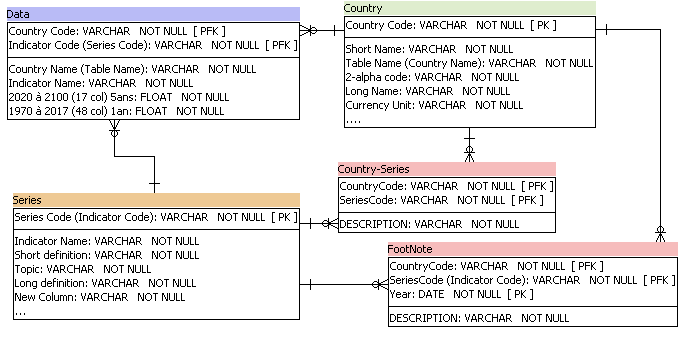

In [89]:
Image("../UML/EduStatsMPD.png")

Les clés proposées dans le MPD ci-dessus pour chaque jeu faciliteraient l'utilisation de la base, sous réserve de quelques modifications (voir modifications plus bas) :
- renommer certaines colonnes afin de lever les ambiguïtés
(ex : Series/"Series Code" -> Series/"Indicator Code")
- supprimer les colonnes redondantes ou inutiles
(ex : Data/"Country Name", accessibles via la clé étrangère "Country Code" en colonne Country/"Table Name")

### 1.1 Données dupliquées ou contradictoires

#### Vérification de l'unicité des clés de chaque table

La description ci-dessus nous a permis de déterminer les colonnes de chaque bases susceptibles de jouer le rôle de clés. Afin de faciliter l'exploitation de la base, il est important que la clé de chaque table soit unique.
Vérifions donc que les tables sont exemptes de doublons :

In [90]:
print("Table Data : Unicité de la clé ('Country Code'&'Indicator Code') {}"\
      .format(uniCle([data["Country Code"], data["Indicator Code"]])))
print("Table Country : Unicité de la clé ('Country Code') {}"\
      .format(uniCle(country["Country Code"])))
print("Table Series : Unicité de la clé ('Series Code') {}"\
      .format(uniCle(series["Series Code"])))
print("Table Country-Series : Unicité de la clé ('CountryCode'&'SeriesCode') {}"\
      .format(uniCle([cnt_ser["CountryCode"], cnt_ser["SeriesCode"]])))
print("Table FootNote : Unicité de la clé ('CountryCode'&'SeriesCode'&'Year') {}"\
      .format(uniCle([footnote["CountryCode"],footnote["SeriesCode"],footnote["Year"]])))

Table Data : Unicité de la clé ('Country Code'&'Indicator Code') True
Table Country : Unicité de la clé ('Country Code') True
Table Series : Unicité de la clé ('Series Code') False
Table Country-Series : Unicité de la clé ('CountryCode'&'SeriesCode') True
Table FootNote : Unicité de la clé ('CountryCode'&'SeriesCode'&'Year') True


Les tables sont bien exemptes de doublons. Pour plus de clarté, on renomme les colonnes contenant des entrées apparentées :

In [91]:
country_c.rename(columns={'Table Name':'Country Name'}, inplace=True)
series_c.rename(columns={'Series Code':'Indicator Code'}, inplace=True)
cnt_ser_c.rename(columns={'CountryCode':'Country Code',
                          'SeriesCode':'Indicator Code',
                         'DESCRIPTION':'Desc Data'}, inplace=True)
footnote_c.rename(columns={'CountryCode':'Country Code',
                          'SeriesCode':'Indicator Code',
                         'DESCRIPTION':'Footnote Data'}, inplace=True)

#### Correspondance des entrées uniques des colonnes apparentées

- Les tables "Data" et "Country" n'ont pas le même nombre d'entrée uniques pour la colonne "Country Code" (voir dataframes inf_data et inf_country) : la table "Country" contient un pays en moins. On cherche à déterminer ce pays :

In [92]:
cnt_lack = Diff(list(data["Country Code"].unique()),list(country["Country Code"].unique()))
print("Codes des pays spécifiques à 'Data' : {}"\
  .format(cnt_lack[0]))
print("Codes des pays spécifiques à 'Country' : {}"\
  .format(cnt_lack[1]))
code = list(cnt_lack[0])[0]
nom = list(data[data["Country Code"]==(list(cnt_lack[0])[0])]["Country Name"].unique())[0]
print("Code et nom du pays à ajouter : {},{}".format(code, nom))

Codes des pays spécifiques à 'Data' : {'VGB'}
Codes des pays spécifiques à 'Country' : set()
Code et nom du pays à ajouter : VGB,British Virgin Islands


La table Country étant supposée renseigner sur tous les pays présents dans la base, on rajoute une ligne dans la base "Country" contenant le pays manquant :

In [93]:
line_vgb = pd.DataFrame([[code]+[None]+[nom]+[None]*(country_c.columns.size-3)],\
                        columns = country_c.columns) # ligne à ajouer
country_c = country_c.append(line_vgb,'sort=False') # ajout en bas de la liste
country_c = country_c.sort_values("Country Code") # remet les lignes en ordre alphabétique de pays
country_c.index = list(np.arange(country_c.index.size)) # renumérote l'index

In [ ]:
#country_c.drop_duplicates(subset='Country Name', keep='first', inplace=True)

- Les entrées uniques des colonnes "Country Name" et "Table Name" des tables "Data" et "Country" ne correspondent pas :

In [94]:
cnt_lack = Diff(list(data_c["Country Name"].unique()),list(country_c["Country Name"].unique()))

print("* Noms des pays spécifiques à 'Data' : {}"\
  .format(sorted(cnt_lack[0])))
print("----------------")
print("* Noms des pays spécifiques à 'Country' : {}"\
  .format(sorted(cnt_lack[1])))
print("----------------")
print("* Nombre de pays non concordants : {}, {}".format(len(cnt_lack[0]), len(cnt_lack[1])))
# liste complète des codes des pays posant problème (data, puis country) :
l_data = sorted([data_c[data_c["Country Name"]==nom_col].iloc[0]["Country Code"] for nom_col in cnt_lack[0]])
l_country = sorted([country_c[country_c["Country Name"]==nom_col].iloc[0]["Country Code"] for nom_col in cnt_lack[1]])
l_pbe = sorted(list(set(l_data + l_country)))
print("----------------")
print("* Liste des codes des {} pays posant problème : {}".format(len(l_pbe), l_pbe))

* Noms des pays spécifiques à 'Data' : ["Cote d'Ivoire", 'Curacao', 'East Asia & Pacific (excluding high income)', 'Europe & Central Asia (excluding high income)', 'Faroe Islands', 'Korea, Dem. People’s Rep.', 'Latin America & Caribbean (excluding high income)', 'Middle East & North Africa (excluding high income)', 'Sao Tome and Principe', 'Sub-Saharan Africa (excluding high income)']
----------------
* Noms des pays spécifiques à 'Country' : ['Curaçao', "Côte d'Ivoire", 'East Asia & Pacific (all income levels)', 'Europe & Central Asia (all income levels)', 'Faeroe Islands', 'Korea, Dem. Rep.', 'Latin America & Caribbean (all income levels)', 'Middle East & North Africa (all income levels)', 'Sub-Saharan Africa (all income levels)', 'São Tomé and Principe']
----------------
* Nombre de pays non concordants : 10, 10
----------------
* Liste des codes des 15 pays posant problème : ['CIV', 'CUW', 'EAP', 'EAS', 'ECA', 'ECS', 'FRO', 'LAC', 'LCN', 'MEA', 'MNA', 'PRK', 'SSA', 'SSF', 'STP']


In [95]:
# tableau comparatif des noms de pays 'posant problème' et ayant le même code dans data et country
mask1 = [li.any() for li in np.array([np.array((data["Country Code"]==n).values) for n in l_pbe]).T]
mask2 = [li.any() for li in np.array([np.array((country["Country Code"]==n).values) for n in l_pbe]).T]
comp = pd.merge(data[mask1], country[mask2], left_on= "Country Code", right_on= "Country Code")
tab_ser = [comp[comp["Country Code"] == pays].iloc[0][['Country Code','Country Name', 'Table Name']] \
           for pays in l_pbe]
my_df = pd.DataFrame(tab_ser, columns = ['Country Code','Country Name', 'Table Name'])
my_df.columns = ['Country Code','Country Name (data_c)', 'Country Name (country_c)' ]
my_df.sort_values(by = ['Country Name (country_c)'], ascending = True, inplace = True)
my_df = my_df.reset_index(drop=True)
my_df.head()

,Country Code,Country Name (data_c),Country Name (country_c)
0,CUW,Curacao,Curaçao
1,CIV,Cote d'Ivoire,Côte d'Ivoire
2,EAP,East Asia & Pacific (excluding high income),East Asia & Pacific
3,EAS,East Asia & Pacific,East Asia & Pacific (all income levels)
4,ECA,Europe & Central Asia (excluding high income),Europe & Central Asia


On conserve les noms de la table 'Data', qui ne contiennent pas de caractères spéciaux, et qui sont plus clairs sur la désignation ('excluding high income' préférable à 'all income levels') :

In [96]:
country_c["Country Name"].replace(to_replace = my_df['Country Name (country_c)'].values, \
                       value = my_df['Country Name (data_c)'].values, inplace=True)

- Les tables "Data" et "Series" ont bien le même nombre d'entrée uniques pour la colonne "Indicator Code" et "Series Code" (voir dataframes inf_data et inf_country) : 3665. Vérifions si ces entrées uniques sont bien les mêmes :

In [97]:
serie_lack = Diff(list(data_c["Indicator Code"].unique()),list(series_c["Indicator Code"].unique()))

print("Nbe d'indicateurs spécifiques à 'Data' : {}"\
  .format(len(serie_lack[0])))
print("Nbe d'indicateurs spécifiques à 'Series' : {}"\
  .format(len(serie_lack[1])))
print("Quelques indicateurs spécifiques à 'Data' :\n {}"\
  .format(sorted(serie_lack[0])[:5]))
print("Quelques indicateurs spécifiques à 'Series' :\n {}"\
  .format(sorted(serie_lack[1])[:5]))

Nbe d'indicateurs spécifiques à 'Data' : 53
Nbe d'indicateurs spécifiques à 'Series' : 53
Quelques indicateurs spécifiques à 'Data' :
 ['SE.SEC.DURS.LO', 'SE.SEC.ENRR.UP.FE', 'UIS.AIR.1.GLAST.GPI', 'UIS.CEAGE.1', 'UIS.E.0.PU.F']
Quelques indicateurs spécifiques à 'Series' :
 ['SE.SEC.DURS.LO ', 'SE.SEC.ENRR.UP.FE ', 'UIS.AIR.1.Glast.GPI', 'UIS.CEAge.1', 'UIS.E.0.Pu.F']


L'échantillon d'indicateurs affichés ci-dessus ne diffèrent en fait que par 1) des espaces 2) des lettres en minuscule dans la table "Series". Vérifions qu'après correction les entrées sont les mêmes :

In [98]:
test_ser = pd.Series([series["Series Code"][i].upper().replace(" ", "")\
                for i in range(series["Series Code"].index.size)],\
                 index = series["Series Code"].index)
test_data = pd.Series([data["Indicator Code"][i].upper().replace(" ", "")\
                for i in range(data["Indicator Code"].index.size)],\
                 index = data["Indicator Code"].index)
lack1 = Diff(list(data["Indicator Code"].unique()),list(test_ser.unique()))
lack2 = Diff(list(test_data.unique()), list(series["Series Code"].unique()))
lack3 = Diff(list(test_data.unique()), list(test_ser.unique()))

print("-----Correction de 'Series' seule :-----")
print("Nbe d'indicateurs spécifiques à 'Data', puis 'Series' : {}, {}"\
  .format(len(lack1[0]), len(lack1[1])))
print("-----Correction de 'Data' seule :-----")
print("Nbe d'indicateurs spécifiques à 'Data', puis 'Series' : {}, {}"\
  .format(len(lack2[0]), len(lack2[1])))
print("-----Correction de 'Data' et 'Series' :-----")
print("Nbe d'indicateurs spécifiques à 'Data', puis 'Series' : {}, {}"\
  .format(len(lack3[0]), len(lack3[1])))

-----Correction de 'Series' seule :-----
Nbe d'indicateurs spécifiques à 'Data', puis 'Series' : 5, 5
-----Correction de 'Data' seule :-----
Nbe d'indicateurs spécifiques à 'Data', puis 'Series' : 58, 58
-----Correction de 'Data' et 'Series' :-----
Nbe d'indicateurs spécifiques à 'Data', puis 'Series' : 0, 0


La correction des noms des deux bases est nécessaire. On effectue la correction des indicateurs dans la base 'Data', dans la base 'Series'.

In [99]:
data_c["Indicator Code"].replace(to_replace = serie_lack[0], \
                        value = [x.upper().replace(" ", "") for x in serie_lack[0]], inplace=True)
series_c["Indicator Code"].replace(to_replace = serie_lack[1], \
                             value =[x.upper().replace(" ", "") for x in serie_lack[1]], inplace=True)

In [100]:
serie_lack2 = Diff(list(data_c["Indicator Code"].unique()),list(series_c["Indicator Code"].unique()))
print("Nbe d'indicateurs spécifiques à 'Data' et à 'Series' après modification : {}, {}"\
      .format(len(serie_lack2[0]),len(serie_lack2[1])))

Nbe d'indicateurs spécifiques à 'Data' et à 'Series' après modification : 0, 0


- Vérifions que les codes d'indicateurs et de pays présents dans les tables "Country-Series" et "Footnote" sont bien dans la liste des codes d'indicateurs de la table "Series" et dans la liste des codes de pays de la table "Country" :

In [101]:
cnt_ser_lack1 = Diff(list(series_c["Indicator Code"].unique()),list(cnt_ser_c["Indicator Code"].unique()))
cnt_ser_lack2 = Diff(list(country_c["Country Code"].unique()),list(cnt_ser_c["Country Code"].unique()))
footnote_lack1 = Diff(list(series_c["Indicator Code"].unique()),list(footnote_c["Indicator Code"].unique()))
footnote_lack2 = Diff(list(country_c["Country Code"].unique()),list(footnote_c["Country Code"].unique()))

print("-------- table 'CountrySeries' --------")
print("Nbe d'indicateurs/de pays spécifiques à 'Series'/'Country' : {}/{}"\
  .format(len(cnt_ser_lack1[0]), len(cnt_ser_lack2[0])))
print("Nbe d'indicateurs/de pays spécifiques à 'CountrySeries' : {}/{}"\
  .format(len(cnt_ser_lack1[1]), len(cnt_ser_lack2[1])))
print("-------- table 'FootNote' --------")
print("Nbe d'indicateurs/de pays spécifiques à 'Series'/'Country' : {}/{}"\
  .format(len(footnote_lack1[0]), len(footnote_lack2[0])))
print("Nbe d'indicateurs/de pays spécifiques à 'FootNote' : {}/{}"\
  .format(len(footnote_lack1[1]), len(footnote_lack2[1])))

-------- table 'CountrySeries' --------
Nbe d'indicateurs/de pays spécifiques à 'Series'/'Country' : 3644/31
Nbe d'indicateurs/de pays spécifiques à 'CountrySeries' : 0/0
-------- table 'FootNote' --------
Nbe d'indicateurs/de pays spécifiques à 'Series'/'Country' : 2196/3
Nbe d'indicateurs/de pays spécifiques à 'FootNote' : 89/0


La base 'CountrySeries' ne contient ni de code de pays ni de code d'indicateur qui ne soit pas dans les bases 'Country' et 'Series', en revanche, la base 'FootNote' contient des codes d'indicateurs erronnés.

In [102]:
print("-------------")
# pays pas dans footnote, 
#print("Quelques code pays seulement dans footnote :\n{}".format(list(footnote_lack2[0])[:15]))

#pays seulement dans footnote
print("Quelques code pays seulement dans footnote :\n{}".format(list(footnote_lack2[1])[:5]))

print("-------------")
# codes indicateurs pas dans footnote,
#print("Quelques indicateurs de 'series' pas dans 'footnote' :\n{}".format(list(footnote_lack1[0])[:3]))

#codes indicateurs seulement dans footnote
print("Quelques indicateurs seulement dans 'footnote' :\n{}".format(list(footnote_lack1[1])[:25]))

-------------
Quelques code pays seulement dans footnote :
[]
-------------
Quelques indicateurs seulement dans 'footnote' :
['se.ADT.LITR.FE.ZS', 'UIS.E.0.Pu.F', 'UIS.XSpendP.4.FDpub.FNnons', 'UIS.XSpendP.2.FDpub.FNnons', 'UIS.SR.1.Glast.GPI', 'UIS.XUNIT.GDPcap.2.FSgov', 'UIS.LR.Ag15t99.GPI', 'UIS.XSpendP.3.FDpub.FNs', 'UIS.XSpendP.2.FDpub.FNs', 'UIS.XGDP.0.FSgov', 'UIS.XUNIT.GDPcap.3.FSgov', 'UIS.LR.Ag65.M', 'se.ADT.LITR.MA.ZS', 'UIS.LP.Ag15t24.M', 'UIS.XGDP.1.Fsgov', 'UIS.XGovExp.IMF.2', 'UIS.E.1.Guk', 'UIS.XUNIT.PPP.3.FSgov', 'UIS.LPP.Ag65', 'UIS.E.23.Pu', 'UIS.E.1.Guk.F', 'UIS.XUNIT.PPP.56.FSgov', 'UIS.LPP.Ag15t99', 'UIS.GER.1t6.GPI', 'UIS.XSpendP.3.FDpub.FNnons']


Les codes d'indicateurs de 'FootNote' contiennent des lettres en minuscules. On applique la même modification que pour les tables 'Data' et 'Series' précédemment (élimination des espaces, passage en majuscules). On vérifie qu'après correction 'FootNote' n'a pas de codes d'indicateurs spécifiques.

In [103]:
footnote_c["Indicator Code"].replace(to_replace = footnote_lack1[1], \
                        value = [x.upper().replace(" ", "") for x in footnote_lack1[1]], inplace=True)
footnote_lack = Diff(list(footnote_c["Indicator Code"].unique()),list(series_c["Indicator Code"].unique()))
print("Nbe d'indicateurs spécifiques à 'Data' et à 'Series' après modification : {}, {}"\
      .format(len(footnote_lack[0]),len(footnote_lack[1])))

Nbe d'indicateurs spécifiques à 'Data' et à 'Series' après modification : 0, 2183


* Y a-t-il une correspondance entre les noms d'indicateurs de la table "Series" et ceux de la table "Data" ? Si oui, comme pour les noms de pays, on ne gardera qu'une des deux colonnes.

On remarque que 462 entrées uniques de la colonne "Indicator Name" de la table "data" ne sont pas dans la table "series" et que le même nombre 462 d'entrées uniques de la même colonne de la table "series" ne sont pas dans la table "data".

In [104]:
indic_lack = Diff(list(data_c["Indicator Name"].unique()),list(series["Indicator Name"].unique()))
#noms d'indicateurs seulement dans data
print("Quelques indicateurs seulement dans 'Data' :\n{}".format(list(indic_lack[0])[:3]))
#noms d'indicateurs seulement dans series
print("Quelques indicateurs seulement dans 'Series' :\n{}".format(list(indic_lack[1])[:3]))
print("----------------")
print("* Nombre de pays non concordants : {}, {}".format(len(indic_lack[0]), len(indic_lack[1])))
# liste complète des codes des indicateurs posant problème (data, puis series) :
l_data = sorted([data_c[data_c["Indicator Name"]==nom_col].iloc[0]["Indicator Code"] for nom_col in indic_lack[0]])
l_series = sorted([series_c[series_c["Indicator Name"]==nom_col].iloc[0]["Indicator Code"] for nom_col in indic_lack[1]])
l_pbe = sorted(list(set(l_data + l_series)))
print("----------------")
print("* Liste des codes de quelques-uns des {} pays posant problème : {}".format(len(l_pbe), l_pbe[:3]))

Quelques indicateurs seulement dans 'Data' :
['Wittgenstein Projection: Percentage of the population age 40-64 by highest level of educational attainment. No Education. Male', 'Wittgenstein Projection: Percentage of the population age 25+ by highest level of educational attainment. Primary. Female', 'SABER: (School Autonomy Accountability) Policy Goal 5: School Accountability']
Quelques indicateurs seulement dans 'Series' :
['Projection: Percentage of the population age 80+ by highest level of educational attainment. Primary. Male', 'Projection: Percentage of the population age 15-19 by highest level of educational attainment. Lower Secondary. Male', 'PASEC: Mean performance on the mathematics scale (100 points) for 5th grade students. Female']
----------------
* Nombre de pays non concordants : 462, 462
----------------
* Liste des codes de quelques-uns des 462 pays posant problème : ['LO.LLECE.MAT3', 'LO.LLECE.MAT3.FE', 'LO.LLECE.MAT3.MA']


In [105]:
# tableau comparatif des noms de pays 'posant problème' et ayant le même code dans data et series
mask1 = [li.any() for li in np.array([np.array((data_c["Indicator Code"]==n).values) for n in l_pbe]).T]
mask2 = [li.any() for li in np.array([np.array((series_c["Indicator Code"]==n).values) for n in l_pbe]).T]
comp = pd.merge(data_c[mask1], series_c[mask2], left_on= "Indicator Code", right_on= "Indicator Code")
tab_ser = [comp[comp["Indicator Code"] == ind].iloc[0][['Indicator Code','Indicator Name_x', 'Indicator Name_y']] \
           for ind in l_pbe]

In [ ]:
# Affichage des noms complets
# comp[['Indicator Code','Indicator Name_x', 'Indicator Name_y', 'Country Name']]\
# .groupby(['Indicator Code','Indicator Name_x','Indicator Name_y']).count()

In [106]:
my_df = pd.DataFrame(tab_ser, columns = ['Indicator Code','Indicator Name_x', 'Indicator Name_y'])
my_df.columns = ['Indicator Code','Indicator Name (data_c)', 'Indicator Name (series_c)' ]
my_df.sort_values(by = ['Indicator Name (series_c)'], ascending = True, inplace = True)
#my_df = my_df.reset_index(drop=True)
my_df.head()

,Indicator Code,Indicator Name (data_c),Indicator Name (series_c)
12342,SP.POP.AG00.FE.UN,"Population, age 0, female","Age population, age 0, female, UNESCO"
12584,SP.POP.AG00.TO.UN,"Population, age 0, total","Age population, age 0, total, UNESCO"
12826,SP.POP.AG01.FE.UN,"Population, age 1, female","Age population, age 01, female, UNESCO"
13068,SP.POP.AG01.TO.UN,"Population, age 1, total","Age population, age 01, total, UNESCO"
18150,SP.POP.AG02.FE.UN,"Population, age 2, female","Age population, age 02, female, UNESCO"


Les noms de la table 'Series' sont généralement plus complets que ceux de 'Data'. On remplace donc les valeurs de 'Indicator Name' dans 'data_c' par celles de la même colonne dans 'series_c' : 

In [ ]:
############# A FAIRE  #########################
# Remplacement par le nom le plus long des deux
# Vérifier quand même que des indicateurs plus courts n'ont pas été remplacés par des plus longs !!!!
#################################################""""""

In [107]:
# remplacement des noms de la colonne data, par ceux de la colonne series
data_c["Indicator Name"].replace(to_replace = my_df['Indicator Name (data_c)'].values, \
                        value = my_df['Indicator Name (series_c)'].values, inplace=True)

In [108]:
#Vérification de la correspondance après modification
verif = Diff(sorted(data_c["Indicator Name"].unique()), sorted(series_c["Indicator Name"].unique()))
list(verif[0])[:5], list(verif[1])[:5]

([], [])

In [109]:
len(data_c["Indicator Name"].unique()), len(series_c["Indicator Name"].unique())

(3665, 3665)

#### Simplification de la base

In [ ]:
############# A FAIRE  #########################
# Fusion des tables footnote_c et cnt_ser_c en une table inf_data_c
#################################################

* Les années de la table "FootNote" sont apparemment dans un format string et précédés de YR ou yr.

In [110]:
# liste des années de la colonne "Year" de la table "FootNote"
print(set(footnote_c["Year"].unique()))

{'YR1985', 'YR2025', 'YR1984', 'YR1997', 'YR1987', 'YR1980', 'YR2000', 'YR2015', 'YR1976', 'YR2011', 'YR1994', 'YR2002', 'YR2007', 'YR1998', 'YR2014', 'YR2005', 'YR2004', 'YR1974', 'YR1975', 'YR1977', 'YR1999', 'YR1990', 'YR1995', 'YR1982', 'YR1973', 'YR1991', 'YR2016', 'YR2012', 'YR1970', 'YR1996', 'YR2045', 'YR2008', 'YR2009', 'YR1983', 'YR1981', 'YR2035', 'YR1971', 'YR2001', 'YR2040', 'YR2050', 'YR1972', 'YR2013', 'YR1988', 'YR2006', 'YR1989', 'YR1979', 'YR1992', 'YR2030', 'YR1986', 'YR1978', 'YR2003', 'YR2017', 'YR1993', 'YR2020', 'yr2012', 'YR2010'}


On remplace les valeurs des chaînes par l'entier correspondant :

In [111]:
# remplacement des années de la colonne 'Year', par les nombres correspondants
ch_ann_uni = list(footnote_c["Year"].unique())
int_ann_uni = [int(('').join(re.findall("[0-9]", chaine))) for chaine in ch_ann_uni]
footnote_c["Year"].replace(to_replace = ch_ann_uni, value = int_ann_uni, inplace=True)

In [112]:
print(set(footnote_c["Year"].unique()))

{2050, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2020, 2025, 2030, 2035, 2040, 2045}


#### Relations bijectives entre colonnes d'une même base

Après vérification de l'unicité des clés choisies pour chaque table, on vérifie la correspondance bijective entre plusieurs paires de colonnes d'une même table, par exemple :
 - les codes de pays et les noms de pays (dans 'Data' et dans 'Country')
 - les codes d'indicateurs et les noms d'indicateurs (dans 'Data' et dans 'Series')

On teste (voir définition de la fonction 'Adeq' plus haut) les couples de colonnes listés ci-dessous :
- Table "Data" : "Country Code", "Country Name" ( Dataframe "data_c" : "Country Code", "Country Name" )
- Table "Data" : "Indicator Code", "Indicator Name" ( Dataframe "data_c" : "Indicator Code", "Indicator Name" )
- Table "Country" : "Country Code", "Short Name" ( Dataframe "country_c" : "Country Code", "Short Name" )
- Table "Country" : "Country Code", "Table Name" ( Dataframe "country_c" : "Country Code", "Country Name" )
- Table "Country" : "Country Code", "Long Name" ( Dataframe "country_c" : "Country Code", "Long Name" )
- Table "Series" : "Series Code", "Indicator Name" ( Dataframe "series_c" : "Indicator Code", "Indicator Name" )

In [113]:
print("Data : {} {}"\
      .format(Adeq(data_c, "Country Code", "Country Name"), Adeq(data_c, "Indicator Code", "Indicator Name")))
print("Country : {} {} {}"\
      .format(Adeq(country_c, "Country Code", "Short Name"), Adeq(country_c, "Country Code", "Country Name"),\
        Adeq(country_c, "Country Code", "Long Name")))
print("Series : {}".format(Adeq(series_c, "Indicator Code", "Indicator Name")))

Data : True True
Country : True True True
Series : True


#### Ajout à la table 'Data'
Pour faciliter le traitement ultérieur des données de la table "Data", on ajoute deux colonnes précisant :
- la région du pays 
- et le topic de l'indicateur

In [114]:
# ajout de la région du pays
data_c = pd.merge( data_c , country_c[['Country Code', 'Region']] , left_on = 'Country Code', right_on = 'Country Code' )
# ajout du topic de l'indicateur
data_c = pd.merge( data_c , series_c[['Indicator Code', 'Topic']] , left_on = 'Indicator Code', right_on = 'Indicator Code' )
cols = list(data_c.columns.values)
cols = cols[-2:]+cols[:-2]
data_c = data_c[cols] # remise en ordre des colonnes

#### Elimination des colonnes sous-remplies

Il existe des colonnes dans les tables 'Country', 'Series', 'Country-Series' et 'Footnote' qui sont très peu remplies. Cependant, les données contenues dans ces tables ne sont pas indispensables au traitement des données chiffrées, qui sont contenues dans la table 'Data'. On n'éliminera donc pas ces colonnes.
En ce qui concerne la table 'Data', elle contient seulement deux colonnes peu remplies (années 2016 et 2017) qu'il n'est pas nécessaire d'effacer pour l'instant.

#### Groupes de pays en régions

* Dans la liste country_c["Country Name"], on remarque 27 pays n'ayant pas de valeur de country["Region"] et country["Income group"]. Ceux-ci sont en fait des groupes de pays. On élimine les données relatives à ces pays (data_c) de notre liste d'intérêt.

In [115]:
# comptage des pays uniques sans région
sans_reg_cnt = country_c[country_c["Region"].isna()]["Country Name"]
li_pays_supp = sans_reg_cnt.values
#['Arab World', 'East Asia & Pacific (excluding high income)','East Asia & Pacific', 'Europe & Central Asia (excluding high income)', 'Europe & Central Asia', 'Euro area', 'European Union', 'Gibraltar', 'High income', 'Heavily indebted poor countries (HIPC)', 'Latin America & Caribbean (excluding high income)', 'Latin America & Caribbean', 'Least developed countries: UN classification', 'Low income', 'Lower middle income', 'Low & middle income', 'Middle East & North Africa', 'Middle income', 'Middle East & North Africa (excluding high income)', 'North America', 'Nauru', 'OECD members', 'South Asia', 'Sub-Saharan Africa (excluding high income)', 'Sub-Saharan Africa', 'Upper middle income', 'British Virgin Islands', 'World']
print(Diff(sans_reg_cnt, sans_reg_cnt) , len(sans_reg_cnt))
print(li_pays_supp) # faux 'pays' à éliminer

(set(), set()) 28
['Arab World' 'East Asia & Pacific (excluding high income)'
 'East Asia & Pacific' 'Europe & Central Asia (excluding high income)'
 'Europe & Central Asia' 'Euro area' 'European Union' 'Gibraltar'
 'High income' 'Heavily indebted poor countries (HIPC)'
 'Latin America & Caribbean (excluding high income)'
 'Latin America & Caribbean'
 'Least developed countries: UN classification' 'Low income'
 'Lower middle income' 'Low & middle income' 'Middle East & North Africa'
 'Middle income' 'Middle East & North Africa (excluding high income)'
 'North America' 'Nauru' 'OECD members' 'South Asia'
 'Sub-Saharan Africa (excluding high income)' 'Sub-Saharan Africa'
 'Upper middle income' 'British Virgin Islands' 'World']


In [116]:
# élimination des faux 'pays' dans "Country"
ind_supp_cnt = sans_reg_cnt.index # index des lignes du tableau country à éliminer (une seule par nom)
country_c.drop(index = ind_supp_cnt, inplace = True)
# élimination des faux 'pays' dans "Data"
sans_reg_data = [data_c[data_c["Country Name"]== col].index for col in li_pays_supp] # liste de listes d'index à retirer
ind_supp_data = [item for sublist in sans_reg_data for item in sublist] # liste des index (applatie)
data_c.drop(index = ind_supp_data, inplace = True)

In [117]:
# vérification
sans_reg_cnt = country_c[country_c["Region"].isna()]["Country Name"]
len(sans_reg_cnt)
sans_reg_cnt = country_c[country_c["Region"].isna()]["Country Name"]
sans_reg_data = data_c[data_c["Region"].isna()]["Country Name"]
print(len(sans_reg_cnt))

0


### 1.2 Données manquantes
#### Comptage des données manquantes par table

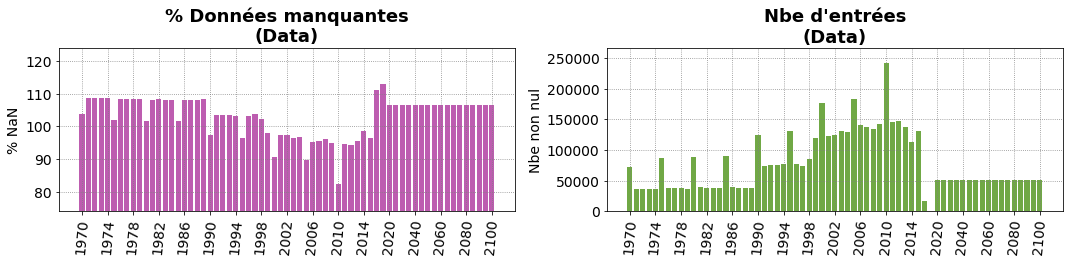

In [118]:
fig = plt.figure(figsize = (18,3))

colors = ["#bd5db0","#70a845","#727bcc","#b49242","#cc566c","#4aad92","#ca6037"]

li_annees = inf_data.columns[4:]
x=li_annees
xlab=[my_str[:11]+"..." if len(my_str)>11 else my_str for my_str in x]
y1=inf_data[li_annees].loc["null"]*100/data_c.shape[0] # % de valeurs nulles
y2=inf_data[li_annees].loc["count"] # nombre de valeurs

plot1 = plt.subplot(1,2,1)
basic_plot("bar", plot1, xlab, y1, xlab[::4], "", "% NaN",  "% Données manquantes\n(Data)", 0)

plot2 = plt.subplot(1,2,2)
basic_plot("bar", plot2, xlab, y2, xlab[::4], "", "Nbe non nul",  "Nbe d'entrées\n(Data)", 1)

plt.show()

In [119]:
# nbe de remplissage minimum/maximum et année correspondante
sel_data = inf_data.loc["count"][4:]
val_min = sel_data.min()
val_max = sel_data.max()

print("- année nbe entrées min, nbe entrées min : \n{}, \n{:.0f}, soit {:.3f}%"\
      .format(sel_data.index[sel_data==val_min], \
              val_min, val_min*100/(data.shape[0])))

print("- année nbe entrées max, nbe entrées max : \n{}, \n{:.0f}, soit {:.3f}%"\
     .format(sel_data.index[sel_data==val_max], \
             val_max, val_max*100/(data.shape[0])))

- année nbe entrées min, nbe entrées min : 
Index(['2017'], dtype='object'), 
143, soit 0.016%
- année nbe entrées max, nbe entrées max : 
Index(['2010'], dtype='object'), 
242442, soit 27.335%


- La table "Data" donnant la valeur d'un indicateur pour une année comporte environ 86 % de données non renseignées.
- Environ 60% de l'ensemble des couples Indicateur/Pays n'a aucune valeur renseignée.
- L'année la mieux renseignée est l'année 2010 (27% des couples Indicateur/Pays, soit plus de 242 000 valeurs), et les moins renseignées sont les années 2016 et 2017 (respectivement 1,8% et 0,016% des couples, soit 16460 et 143 valeurs)

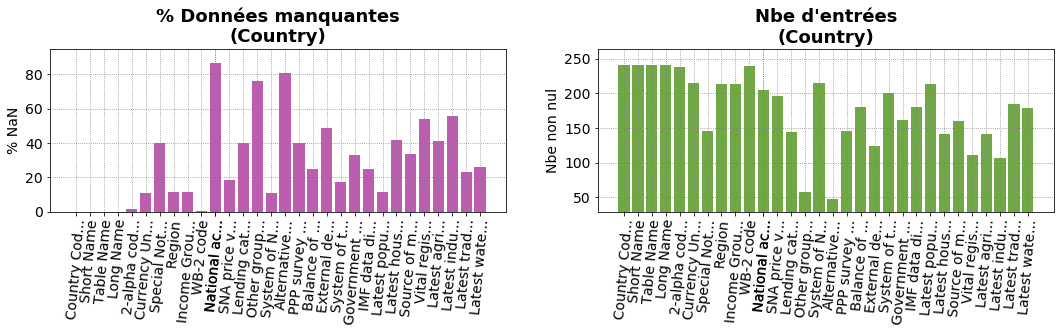

In [120]:
fig = plt.figure(figsize = (18,3))

x=inf_country.columns
xlab=[my_str[:11]+"..." if len(my_str)>11 else my_str for my_str in x]
y1=inf_country.loc["null"]*100/country.shape[0]  # % de valeurs nulles
y2=inf_country.loc["count"] # nombre de valeurs

plot1 = plt.subplot(1,2,1)
basic_plot("bar", plot1, xlab, y1, xlab, "", "% NaN",  "% Données manquantes\n(Country)", 0)

plot2 = plt.subplot(1,2,2)
basic_plot("bar", plot2, xlab, y2, xlab, "", "Nbe non nul",  "Nbe d'entrées\n(Country)", 1)

plt.show()

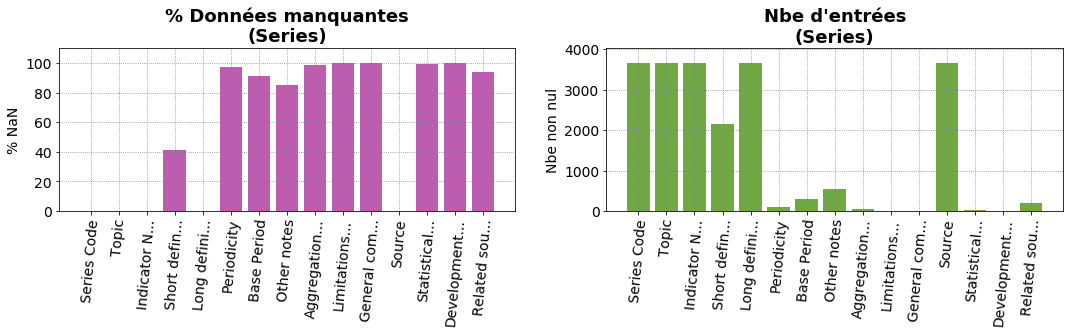

In [121]:
fig = plt.figure(figsize = (18,3))

x=inf_series.columns
xlab=[my_str[:11]+"..." if len(my_str)>11 else my_str for my_str in x]
y1=inf_series.loc["null"]*100/series.shape[0]  # % de valeurs nulles
y2=inf_series.loc["count"] # nombre de valeurs

plot1 = plt.subplot(1,2,1)
basic_plot("bar", plot1, xlab, y1, xlab, "", "% NaN",  "% Données manquantes\n(Series)", 0)

plot2 = plt.subplot(1,2,2)
basic_plot("bar", plot2, xlab, y2, xlab, "", "Nbe non nul",  "Nbe d'entrées\n(Series)", 1)

plt.show()

In [122]:
print("la table 'CountrySeries' contient {} entrées nulles".format(inf_cnt_ser.loc["null"].sum()))
print("la table 'FootNote' contient {} entrées nulles".format(inf_footnote.loc["null"].sum()))

la table 'CountrySeries' contient 0 entrées nulles
la table 'FootNote' contient 0 entrées nulles


* Nombre de régions et de pays par régions

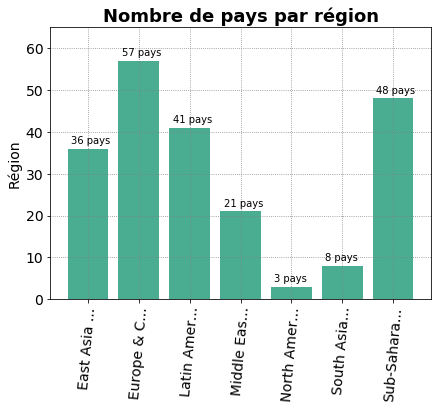

In [123]:
# code de pays et région associée

fig = plt.figure(figsize = (15,5))

df2 = country_c[['Country Name', 'Region']].groupby('Region').count()
li_region = list(df2.index)
x = li_region
xlab = [my_str[:10]+"..." if len(my_str)>8 else my_str for my_str in x]
y1 = df2.values.reshape(len(df2.values),)
#y2 = 

# Nombre de pays par région
plot1 = plt.subplot(1,2,1)
basic_plot("bar", plot1, xlab, y1, xlab, "", "Région",  "Nombre de pays par région", 5)
labels = [ '{:.0f} pays'.format(y1[i]) for i in range(len(y1))] 
for label,xlab, y1 in zip(labels, xlab, y1):
    plt.annotate(label, xy=(xlab, y1), xytext=(-17, 3),
        textcoords='offset points', ha='left', va='bottom' )
plt.ylim(0,65)

# Nombre d'habitants cumulés par région
# plot2 = plt.subplot(1,2,2)
# basic_plot("bar", plot2, xlab, y2, xlab, "", "Région",  "Nombre d'habitants par région", 5)
# labels = [ '{:.0f} pays'.format(y2[i]) for i in range(len(y))] 
# for label,xlab, y2 in zip(labels, xlab, y2):
#     plt.annotate(label, xy=(xlab, y2), xytext=(-17, 3),
#         textcoords='offset points', ha='left', va='bottom' )
# plt.ylim(0,65)

plt.show()

#### Indicateurs sous-remplis

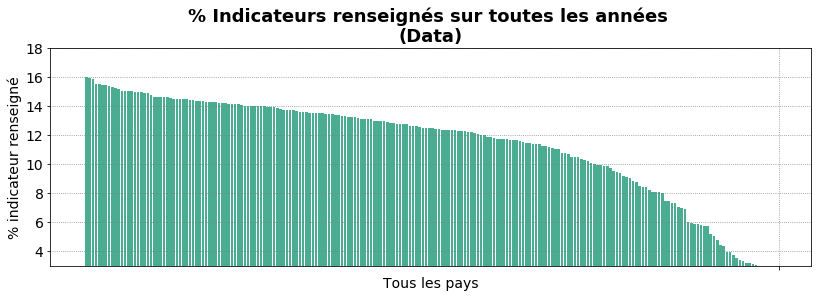

In [124]:
fig = plt.figure(figsize = (30,4))

# tableau du pourcentage d'indicateurs renseignés par pays ()
gp = data_c.groupby(['Country Name']).count()
nb_col_an = data_c[4:].shape[1]
nb_indic = series_c['Indicator Code'].shape[0]
nb_max = (nb_col_an*nb_indic)
tab = gp[gp.columns[3:]].sum(axis=1)*100/nb_max
tab.sort_values(ascending=False,inplace=True)

x=tab.index
xlab=[my_str[:8]+"..." if len(my_str)>8 else my_str for my_str in x]
y=tab

plot1 = plt.subplot(1,2,1)
basic_plot("bar", plot1, xlab, y, '', "Tous les pays", "% indicateur renseigné",  "% Indicateurs renseignés sur toutes les années \n(Data)", 5)

plt.show()

In [130]:
# Pourcentage d'indicateurs par pays (nbe d'années renseignées/nbe années total), region par région




In [132]:
tab_df[0].head()

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
Country Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
American Samoa,2,9,23,23,23,23,21,22,24,17,47,18,30,22,50,41,47,46,46,49,48,25,46,14,14,14,14,14,9,10,4,4,8,8,8,8,10,16,8,8,8,8,8,8,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Australia,440,150,106,131,150,510,150,143,145,145,502,152,147,149,154,514,153,156,160,160,706,353,353,417,410,856,407,386,458,623,1065,582,624,824,619,1113,846,847,747,861,1425,872,887,784,577,800,88,0,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308
Brunei Darussalam,474,120,176,252,189,631,278,335,333,337,684,358,338,366,373,435,232,113,92,94,610,452,441,452,447,712,284,300,442,576,922,612,512,660,721,1155,783,795,794,785,1139,770,747,756,704,382,87,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Cambodia,412,120,106,102,55,410,50,50,50,50,416,73,73,73,73,433,84,74,82,86,612,276,240,258,347,756,263,498,598,613,1203,839,811,678,769,1234,767,839,745,463,1621,626,632,599,756,669,72,0,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308
China,438,75,74,84,114,474,136,136,136,142,520,136,158,131,144,515,155,180,162,197,802,410,422,423,444,847,553,534,320,427,776,403,375,457,293,653,563,622,619,713,1368,566,642,678,561,751,72,0,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308


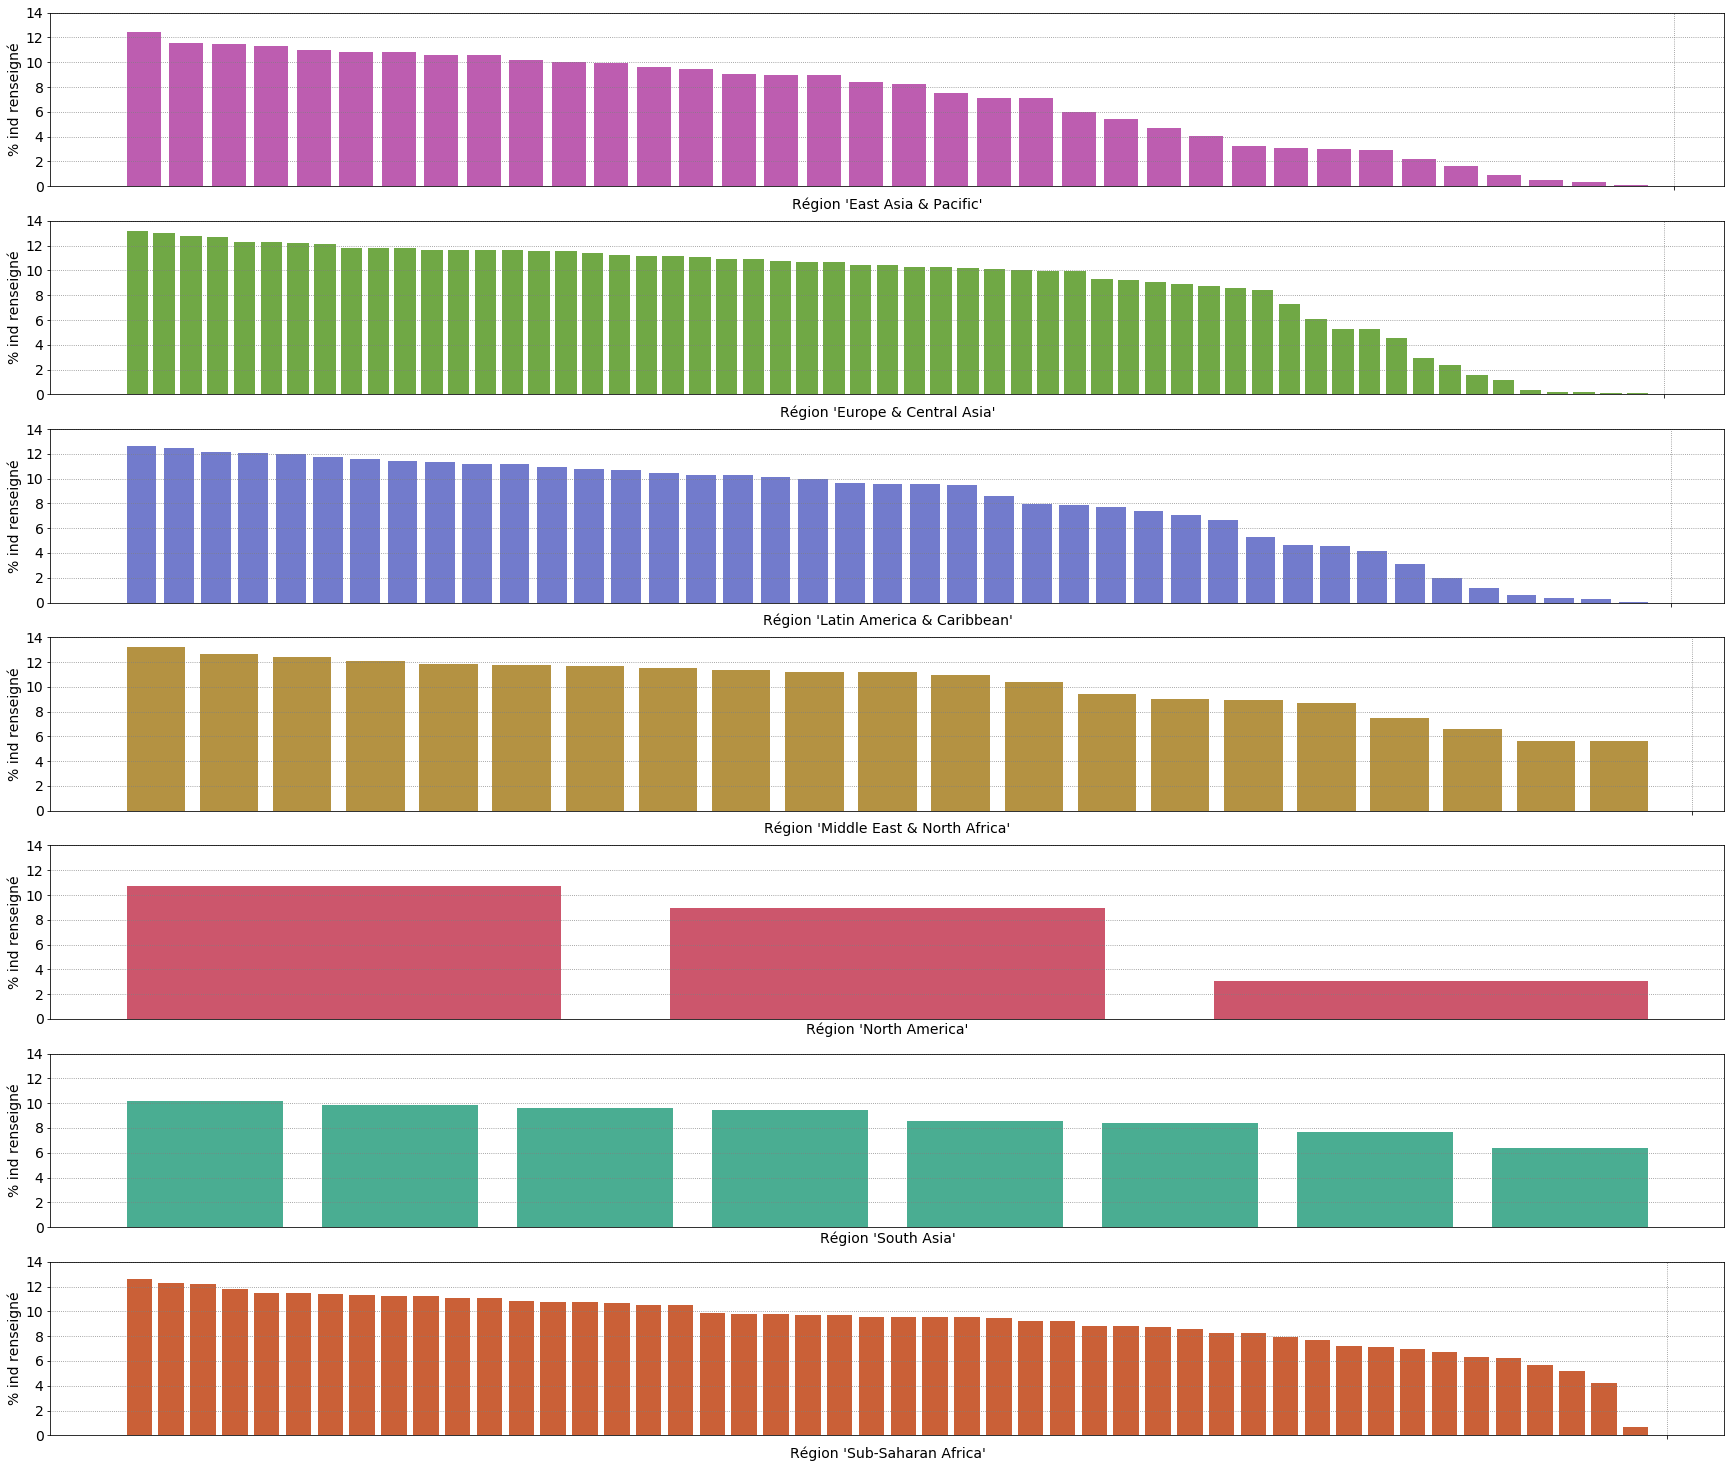

In [157]:
# Pour chaque région
fig = plt.figure(figsize = (30,30))


# tableau du pourcentage d'indicateurs renseignés par pays ()
gp = data_c.groupby(['Country Name']).count()
nb_col_an = data_c[4:].shape[1]
nb_indic = series_c['Indicator Code'].shape[0]
nb_max = (nb_col_an*nb_indic)

#tab = gp[gp.columns[3:]].sum(axis=1)*100/nb_max
#tab.sort_values(ascending=False,inplace=True)

tab_df = [data_c.groupby(['Region', 'Country Name']).count().loc[reg][li_annees] for reg in li_region]

tab_plot = []
for i in range(len(tab_df)):
    x=tab_df[i].index
    xlab=[my_str[:8]+"..." if len(my_str)>8 else my_str for my_str in x]
    y=tab_df[i].sum(axis=1)*100/nb_max # % des indicateurs pour toutes les années
    y.sort_values(ascending=False,inplace=True)
    tab_plot.append(plt.subplot(len(tab_df)+1,1,i+1))
    basic_plot("bar", tab_plot[i], xlab, y, '', "Région '"+ li_region[i] + "'", "% ind renseigné",  "", i)
    plt.ylim(0,14)
#plt.title("% Indicateurs renseignés sur toutes les années \n(Data)")
plt.show()

In [146]:
tab_plot = []
tab_plot.append(plt.subplot(1,2,1))

In [ ]:
########## idem mais avec tranches d'années
fig = plt.figure(figsize = (30,4))

# tableau du pourcentage d'indicateurs renseignés par pays ()
gp = data_c.groupby(['Country Name']).count()
nb_col_an = data_c[4:].shape[1]
nb_indic = series_c['Indicator Code'].shape[0]
nb_max = (nb_col_an*nb_indic)
tab = gp[gp.columns[3:]].sum(axis=1)*100/nb_max
tab.sort_values(ascending=False,inplace=True)

x=tab.index
xlab=[my_str[:8]+"..." if len(my_str)>8 else my_str for my_str in x]
y=tab

plot1 = plt.subplot(1,2,1)
basic_plot("bar", plot1, xlab, y, '', "Tous les pays", "% indicateur renseigné",  "% Indicateurs renseignés sur toutes les années \n(Data)", 5)

plt.show()

## 2. Exploration des données

Les indicateurs qui nous intéressent sont ceux des dernières années.
On cherche à savoir :
- combien d'indicateurs environ sont disponibles dans les dernières années
- quels sont les pays qui ont le plus d'indicateurs disponibles dans les dernières années
- quels sont les indicateurs le plus souvent disponible 

### Nombres d'indicateurs disponibles selon les années

In [ ]:
# Tableau des nombres d'indicateurs dispo pour chaque pays et chaque année 
nb_ind_cnt = data_c.groupby(['Country Name']).count()[li_annees]
# Pays ayant un nbe d'indicateur non nul en 2017
#nb_ind_cnt[nb_ind_cnt['2017']!=0]

In [ ]:
# Nbe de pays ayant un nbe d'indicateur supérieur à n en fonction des années

def calc_nb_pay_rens (tab_n):
    tab = [ [nb_ind_cnt[nb_ind_cnt[str(i)]>j].index.size for i in years] for j in tab_n ]
    res = np.array(tab).T
    return res

countrys = [nb_ind_cnt.index[i][0] + " - " + nb_ind_cnt.index[i][1] for i in range(nb_ind_cnt.index.size)]
years = list(range(1970,2018))+list(range(2020,2105,5))
tab_n = [0,2,10,50,100, 200, 500]
x = years
y = calc_nb_pay_rens(tab_n)
len(y[:, 1]), len(x)

In [ ]:
fig = plt.figure(figsize = (18,6))

colors = ["#bd5db0","#70a845","#727bcc","#b49242","#cc566c","#4aad92","#ca6037"]
labels = ["i="+str(i) for i in tab_n]

plot1 = plt.subplot(1,2,1)
[plot1.plot(x, y[:,i], '-o', label = labels[i], color = colors[i]) for i in range(len(tab_n))]
plot1.set_ylim(0,250)
plot1.legend(loc = 'lower right')
plot1.set_xlabel("années", fontsize = 14)
plot1.set_ylabel("nbe de pays", fontsize = 14)
plot1.set_title("Pays ayant plus de i indicateurs", fontsize = 18, fontweight = 'bold')

plot2 = plt.subplot(1,2,2)
[plot2.plot(x, y[:,i], '-o', label = labels[i], color = colors[i]) for i in range(len(tab_n))]
plot2.set_xlim(1980,2018)
plot2.set_ylim(75,250)
plot2.legend(loc = 'lower right')
plot2.set_xlabel("années", fontsize = 14)
plot2.set_ylabel("nbe de pays", fontsize = 14)
plot2.set_title("Pays ayant plus de i indicateurs (zoom)", fontsize = 18, fontweight = 'bold')
plt.show() 

- Tous les pays ont au moins 1 indicateur
- 167 pays ont des projections d'indicateurs (entre 200 et 500)
- les données sont très rares pour l'année 2018 (7 indicateurs pour la grande majorité des pays

In [ ]:

### Heatmap du nombre d'indicateurs (pays/années)
fig = plt.figure(figsize = (28,12))
heat_map = sns.heatmap(nb_ind_cnt)
#####################

### Exploration des mots clés dans les noms d'indicateurs

In [ ]:
list_pop = ["in", "of", "a", "and", "Per", "by", "the", "with", "to", "from",\
            "for", "who", "on", "are"] # liste des mots non considérés

# génération dictionnaire effectif mots-clés 
dic_occs = enum_mots_cmpt(data["Indicator Name"], 30) # à parti des noms d'indicateurs dans "Data"
dic_occs = filt_dict(dic_occs,list_pop) # filtrage des mots indésirables
dic_occs2 = enum_mots_cmpt(data["Country Name"], 30) # à partir des indicateurs uniques
dic_occs2 = filt_dict(dic_occs,list_pop) # filtrage des mots indésirables

nuageMots(dic_occs), nuageMots(dic_occs2)

In [ ]:
histMots(dic_occs), histMots(dic_occs2)

PBE A REGLER : les deux graphes sortent les mêmes résultats !!!!

### Détection des outliers

In [ ]:
# prend un tableau de valeurs, calcule la moyenne, l'écart type
# et renvoie les valeurs au-delà ou en-deça de x fois l'écart type
def detOutliers(df,col,x):
    moy = df[col].mean()
    std = df[col].std()
    out_val = [nb for nb in df[col].values if ((nb<moy-(x*std)) or (nb>moy+(x*std)))]
    return df[df[col].isin(out_val)]

my_tab = [1,3,0,2,5]
df = pd.DataFrame({'my_col' : my_tab})

tab_df = [detOutliers(df, "my_col",x) for x in np.linspace(0,2.5,7)]
[plt.plot(df.index, df["my_col"].values,'o-', label = "x = "+str(df.index.values)) for df in tab_df]
plt.legend()
plt.show()

In [ ]:
### violon plot (seaborn)
# montre la distribution également
# éliminer les quantiles extrêmes (zscore supérieur à 3...)
# chercher des indicateurs pertinents, valider, itérer.

In [ ]:
fig, (plot1, plot2) = plt.subplots(1, 2, figsize = (25,6), gridspec_kw={'width_ratios': [3, 2]})
x=[1,2,3]
y=[8,7,6]
# plot1.plot(x, y)
# plot2.plot(y, x)

plot1 = plt.subplot(1,2,1)
#data.boxplot(column = li_annees)
plot1.boxplot(data_c[data_c.columns['1970':'2017']])
#plot1.set_ylim(-300,550050)

# plot2 = plt.subplot(1,2,2)
# plot2.boxplot(data_val_0)
# #data[data.columns[52:]].dropna(inplace = False).boxplot(data.columns[52:])
# plot2.set_ylim(-3,20)

plt.show()

## -------------- BROUILLONS -------------

In [ ]:
## groupby, merge, join, concat etc.

#DataFrame.merge(right, how='inner', on=None, left_on=None, right_on=None, left_index=False,
# right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)
df1 = pd.DataFrame({'lkey': ['foo', 'bar', 'baz', 'foo'], 'value': [1, 2, 3, 1], 'value2': [100, 200, 300, 500]})
df2 = pd.DataFrame({'rkey': ['foo', 'bar', 'baz', 'foo'], 'value': [5, 6, 7, 8]})
df1

In [ ]:
#df1.merge(df2, right_on='rkey')
df1.merge(df2, left_on = 'lkey', right_on='rkey')
df1.groupby(['value', 'lkey']).count()


In [ ]:
my_gp = data.groupby(['Country Name']).count()

In [ ]:
my_gp[my_gp.columns[3:]].sum(axis=1) # tableau du nbe total d'indicateurs valables multiannées

In [ ]:
my_gp.sum(axis=0)

In [ ]:
my_df = data[data["Indicator Code"]=='SP.POP.1524.TO.UN']
my_df.dropna(how = 'all', inplace = True)
x = my_df["Country Name"]
y = my_df["2000"]
# pop de 15 à 24 ans en 2000 selon les pays :
plt.plot(x,y)
plt.show()

In [ ]:
tab1 = [4, 0,1,np.nan,50]
tab2 = [10, 20,30,np.nan,50]
tab3 = [np.nan, np.nan,np.nan,3,np.nan]
df = pd.DataFrame([tab1,tab2,tab3]).rename(index={0:'coucou', 1:'recou', 2:'rerec'})
df["total"] = [10,100,1000]
df

In [ ]:
# En cas de noms de colonnes différents :
df1 = pd.DataFrame({'code1': ['B', 'J', 'L', 'S'],\
                    'employee': ['Bob', 'Jake', 'Lisa', 'Suez'],
                    'department': ['Accounting', 'Engineering', 'Engineering', 'HR']})
df2 = pd.DataFrame({'code2': ['L', 'B', 'J', 'S'],\
                    'emp_name': ['Liça', 'Bobby', 'Jack', 'Sue'],
                    'date': [2004, 2008, 2012, 2014]})

Diff(df1["employee"].unique(),df2["emp_name"].unique())
lipbe = ['B','L', 'S','J']
mask1 = [li.any() for li in np.array([np.array((df1["code1"]==n).values) for n in lipbe]).T]
mask2 = [li.any() for li in np.array([np.array((df2["code2"]==n).values) for n in lipbe]).T]

# merge de 2 sélections de dataframe (noms posant problème)
comp = pd.merge(df1[mask1], df2[mask2], left_on= "code1", right_on= "code2")
comp[['code1','employee', 'emp_name']]

In [ ]:
df1.replace(to_replace=comp['employee'].values, value=comp['emp_name'].values, inplace=True)
df1

In [ ]:
df3 = pd.DataFrame({'code1': ['B', 'J', 'L', 'S'],\
                    'employee': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    })
df4 = pd.DataFrame({'code1': ['B', 'J', 'L', 'S'],\
                    'emp': ['Bob', 'Jack', 'Liza', 'Suez'],
                    })

In [ ]:
df3["employee"].loc[1] = df4["emp"].loc[1]
df3["employee"][df3["employee"]=='Lisa']  = df4["emp"].loc[df3[df3["employee"]=='Lisa'].index]
df3

In [ ]:
df = pd.DataFrame(np.arange(10).reshape(-1, 2), columns=['A', 'B'])
df

In [ ]:
df['B'].replace(to_replace = [6,8,5], value = [60,80,50], inplace = True)
df

In [ ]:
m = df % 1 == 0 # pas trouvé mieux pour faire un masque rempli de 'True'
m['B'] = False
dfmod = df
dfmod['A']=df['B']
dfmod['B']=df['A']
df.where(m, dfmod)
#dfObj = pd.DataFrame(columns=['User_ID', 'UserName', 'Action'], index=['a', 'b', 'c'])

In [ ]:
df.where(m, dfmod) # quand c'est un multiple de trois, laisser df, sinon mettre -df

In [ ]:
# Sélection des données pour l'indicateur région
coucou1 = country_c.where(country_c["Region"]=='Latin America & Caribbean').dropna(how = 'all', inplace=False)
coucou2 = country_c[country_c["Region"]=='Latin America & Caribbean']
Diff(coucou, coucou2)

In [ ]:
coucou3 = country_c[country_c["Region"].isnull()]
coucou1.shape, coucou2.shape, coucou3.shape

In [ ]:
# nombre d'indicateurs par pays pour chaque année
df1 = data_c.groupby(['Country Name', 'Country Code']).count()[li_annees]
# liste des codes pays et de leurs régions
df2 = country_c[['Country Code', 'Region']]
# Nombre d'indicateurs par région
df3 = pd.merge(df1, df2, left_on = 'Country Code', right_on = 'Country Code')
df3.head()